# Graph — End‑to‑End Stress Notebook

**Goal:** build a realistic, multi‑layer biological interaction graph with **tens of thousands** of vertices and a mix of **binary edges, hyperedges, and vertex–edge (edge‑entity) links**, then **exercise every public API**: layers, presence queries, propagation (`shared` / `all`), views, analytics, set operations, aggregations, subgraph/copy, deletions, auditing, and memory usage.

In [2]:
# Robust import of Graph
import os, importlib.util, random, math, time
from time import perf_counter

import sys, os
sys.path.insert(0, os.path.abspath(".."))  # must be the parent folder that CONTAINS 'graphglue'

from graphglue.core.graph import Graph
from graphglue.adapters.networkx import to_backend, to_nx, from_nx

G = Graph(directed=True)


import polars as pl

In [4]:
# Parameters — choose a scale
# - DEMO runs fast on laptops
# - STRESS creates 10^4–10^5 scale objects; adjust upward to your machine limits

SCALE = "DEMO"  # "DEMO" or "STRESS"

if SCALE.upper() == "DEMO":
    N_PROTEINS = 5_00
    N_TRANSCRIPTS = 2_00
    N_METABOLITES = 1_00
    N_EDGE_ENTITIES = 40
    N_BIN_EDGES = 25_00       # binary protein-protein interactions (base layer)
    N_HYPER_COMPLEX = 1_00    # undirected complexes
    N_HYPER_CASCADE = 1_00    # directed signaling cascades
    N_vertex_EDGE_BIDIR = 2_00  # vertex<->edge-entity links (counted as pairs)
else:
    N_PROTEINS = 30_000
    N_TRANSCRIPTS = 12_000
    N_METABOLITES = 8_000
    N_EDGE_ENTITIES = 2_500
    N_BIN_EDGES = 160_000
    N_HYPER_COMPLEX = 4,000    # use commas? We'll correct below to int
    N_HYPER_CASCADE = 4_000
    N_vertex_EDGE_BIDIR = 10_000

# fix typo for N_HYPER_COMPLEX in STRESS case
if isinstance(N_HYPER_COMPLEX, tuple):
    N_HYPER_COMPLEX = 4000

LAYERS = ["Healthy","Stressed","Disease","DrugA","DrugB"]
ORDERED_FOR_TEMPORAL = ["Healthy","Stressed","Disease","DrugA","DrugB"]

# How many parallel edges to create as duplicates between random pairs
N_PARALLEL_DUPES = max(1, N_BIN_EDGES // 20)

# Fraction of vertices seeded into each non-default layer (to make propagate='shared'/'all' meaningful)
SEED_FRAC_PER_LAYER = 0.6


In [6]:
# Helpers

def rand_weight(base=1.0, jitter=0.5):
    # positive weight with variability
    w = base + (random.random() - 0.5) * 2 * jitter
    return max(0.01, w)

def try_to_pandas(df):
    if df is None:
        return None
    if 'polars' in type(df).__module__.lower():
        return df.to_pandas() if hasattr(df, "to_pandas") else None
    return df  # assume already pandas-like

def head_df(df, n=5):
    p = try_to_pandas(df)
    return p.head(n) if p is not None else None


In [8]:
# Build graph & layers
t0 = perf_counter()
G = Graph(directed=True)

for lid in LAYERS:
    G.add_layer(lid, desc=f"condition={lid}")
G.set_active_layer(LAYERS[0])
build_layers_time = perf_counter() - t0
print("Layers ready:", G.list_layers(), "active:", G.get_active_layer())


Layers ready: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB'] active: Healthy


In [10]:
# ---- progress helpers ----
from time import perf_counter
try:
    from tqdm.auto import tqdm  # uses notebook bar if available
    _TQDM = True
except Exception:
    _TQDM = False

def prog_iter(it, total=None, desc="", mininterval=0.25):
    """Wrap any iterable with a progress display (tqdm if available, else no-op)."""
    if _TQDM:
        return tqdm(it, total=total, desc=desc, mininterval=mininterval, leave=False)
    return it

def batched(iterable, batch_size):
    """Yield lists of size <= batch_size (Py<3.12 compatible)."""
    buf = []
    for x in iterable:
        buf.append(x)
        if len(buf) == batch_size:
            yield buf
            buf = []
    if buf:
        yield buf

In [12]:
import numpy as np
rng = np.random.default_rng(42)

t = perf_counter()

proteins    = [f"P{i}"  for i in range(1, N_PROTEINS+1)]
transcripts = [f"T{i}"  for i in range(1, N_TRANSCRIPTS+1)]
metabolites = [f"M{i}"  for i in range(1, N_METABOLITES+1)]
edge_entities = [f"EE{i}" for i in range(1, N_EDGE_ENTITIES+1)]

add_vertex = G.add_vertex
add_edge_entity = G.add_edge_entity

# --- Seed vertices in "Healthy" (progress) ---
kinase_mask = rng.random(len(proteins)) < 0.15
for batch in prog_iter(batched(list(zip(proteins, kinase_mask)), 2000),
                       total=(len(proteins)+1999)//2000, desc="Healthy: proteins"):
    for p, is_kinase in batch:
        if is_kinase:
            add_vertex(p, layer="Healthy", family="kinase", kind="protein")
        else:
            add_vertex(p, layer="Healthy", kind="protein")

for batch in prog_iter(batched(transcripts, 4000),
                       total=(len(transcripts)+3999)//4000, desc="Healthy: transcripts"):
    for tvertex in batch:
        add_vertex(tvertex, layer="Healthy", kind="transcript")

for batch in prog_iter(batched(metabolites, 4000),
                       total=(len(metabolites)+3999)//4000, desc="Healthy: metabolites"):
    for m in batch:
        add_vertex(m, layer="Healthy", kind="metabolite")

# --- Edge-entities (progress) ---
pathways = np.array(["glycolysis","tca","mapk","pi3k"])
drawn_pathways = pathways[rng.integers(0, len(pathways), size=len(edge_entities))]
for batch in prog_iter(batched(list(zip(edge_entities, drawn_pathways)), 5000),
                       total=(len(edge_entities)+4999)//5000, desc="Healthy: edge-entities"):
    for ee, pw in batch:
        add_edge_entity(ee, layer="Healthy", role="enzyme", pathway=pw)

# --- Seed presence into other layers (progress per layer) ---
p_keep = SEED_FRAC_PER_LAYER
for lid in prog_iter(LAYERS[1:], total=len(LAYERS)-1, desc="Seeding other layers"):
    pmask = rng.random(len(proteins))    < p_keep
    tmask = rng.random(len(transcripts)) < p_keep
    mmask = rng.random(len(metabolites)) < p_keep

    for batch in prog_iter(batched(list(zip(proteins, pmask)), 4000),
                           total=(len(proteins)+3999)//4000, desc=f"{lid}: proteins", mininterval=0.3):
        for n, keep in batch:
            if keep:
                add_vertex(n, layer=lid, kind="protein")

    for batch in prog_iter(batched(list(zip(transcripts, tmask)), 4000),
                           total=(len(transcripts)+3999)//4000, desc=f"{lid}: transcripts", mininterval=0.3):
        for n, keep in batch:
            if keep:
                add_vertex(n, layer=lid, kind="transcript")

    for batch in prog_iter(batched(list(zip(metabolites, mmask)), 4000),
                           total=(len(metabolites)+3999)//4000, desc=f"{lid}: metabolites", mininterval=0.3):
        for n, keep in batch:
            if keep:
                add_vertex(n, layer=lid, kind="metabolite")

build_vertices_time = perf_counter() - t
print("vertices done. #vertices:", G.number_of_vertices(),
      "Edge-entities:", sum(1 for k,v in G.entity_types.items() if v=='edge'),
      "time(s)=", round(build_vertices_time, 3))

Healthy: proteins:   0%|          | 0/1 [00:00<?, ?it/s]

Healthy: transcripts:   0%|          | 0/1 [00:00<?, ?it/s]

Healthy: metabolites:   0%|          | 0/1 [00:00<?, ?it/s]

Healthy: edge-entities:   0%|          | 0/1 [00:00<?, ?it/s]

Seeding other layers:   0%|          | 0/4 [00:00<?, ?it/s]

Stressed: proteins:   0%|          | 0/1 [00:00<?, ?it/s]

Stressed: transcripts:   0%|          | 0/1 [00:00<?, ?it/s]

Stressed: metabolites:   0%|          | 0/1 [00:00<?, ?it/s]

Disease: proteins:   0%|          | 0/1 [00:00<?, ?it/s]

Disease: transcripts:   0%|          | 0/1 [00:00<?, ?it/s]

Disease: metabolites:   0%|          | 0/1 [00:00<?, ?it/s]

DrugA: proteins:   0%|          | 0/1 [00:00<?, ?it/s]

DrugA: transcripts:   0%|          | 0/1 [00:00<?, ?it/s]

DrugA: metabolites:   0%|          | 0/1 [00:00<?, ?it/s]

DrugB: proteins:   0%|          | 0/1 [00:00<?, ?it/s]

DrugB: transcripts:   0%|          | 0/1 [00:00<?, ?it/s]

DrugB: metabolites:   0%|          | 0/1 [00:00<?, ?it/s]

vertices done. #vertices: 800 Edge-entities: 40 time(s)= 18.238


In [14]:
# Binary edges (PPIs mostly among proteins), defined in Healthy then layered variants
t = perf_counter()
ppis = []
for _ in range(N_BIN_EDGES):
    u = random.choice(proteins)
    v = random.choice(proteins)
    if u == v:
        continue
    # random directedness: ~80% directed, 20% undirected
    directed = (random.random() < 0.8)
    e = G.add_edge(u, v, layer="Healthy", weight=rand_weight(1.2, 0.6), edge_directed=directed)
    ppis.append(e)

# parallel dupes between random pairs
for _ in range(N_PARALLEL_DUPES):
    # pick a previously created edge id, and add another parallel edge for same (u,v)
    # We'll sample pair via G.edge_definitions
    eid = random.choice(ppis)
    u, v = G.edge_definitions[eid][0], G.edge_definitions[eid][1]
    G.add_parallel_edge(u, v, weight=rand_weight(1.0, 0.3))

# Per-layer variants: copy presence and tweak weights
for eid in ppis:
    base_w = G.edge_weights[eid]
    for lid in LAYERS[1:]:
        G.add_edge_to_layer(lid, eid)
        # apply layer-specific weight modifier
        factor = {
            "Stressed": rand_weight(1.10, 0.10),
            "Disease":  0.7 if random.random() < 0.4 else rand_weight(1.30, 0.15),
            "DrugA":    rand_weight(0.9, 0.25),
            "DrugB":    rand_weight(1.2, 0.20),
        }[lid]
        G.set_edge_layer_attrs(lid, eid, weight=base_w * factor, note=f"layer={lid}")
build_binary_time = perf_counter() - t
print("Binary edges built:", len(ppis), "total edges now:", G.number_of_edges())


Binary edges built: 2495 total edges now: 2620


In [52]:
# Propagation semantics via add_edge(..., propagate=...)
t = perf_counter()
# Ensure varied vertex presence across layers for a few pairs
pairs = [(random.choice(proteins), random.choice(transcripts)) for _ in range(2000)]
for u,v in pairs:
    # 'shared': only layers where both endpoints already present
    G.add_edge(u, v, layer="Healthy", edge_type="regular", weight=rand_weight(0.8,0.2), propagate="shared")
pairs2 = [(random.choice(proteins), random.choice(metabolites)) for _ in range(2000)]
for u,v in pairs2:
    # 'all': appears everywhere either endpoint exists (pulls other endpoint in)
    G.add_edge(u, v, layer="Healthy", edge_type="regular", weight=rand_weight(0.8,0.2), propagate="all")

build_propagation_time = perf_counter() - t
print("Propagation examples added (shared/all).")


Propagation examples added (shared/all).


In [18]:
# Hyperedges: undirected complexes, directed cascades
t = perf_counter()

complex_ids = []
for _ in range(N_HYPER_COMPLEX):
    size = random.choice([3,4,5,6])
    members = set(random.sample(proteins, size))
    hid = G.add_hyperedge(members=members, layer="Healthy", weight=rand_weight(1.0, 0.2), tag="complex")
    complex_ids.append(hid)
    for lid in LAYERS[1:]:
        G.add_edge_to_layer(lid, hid)

cascade_ids = []
tries = 0
while len(cascade_ids) < N_HYPER_CASCADE and tries < N_HYPER_CASCADE*5:
    tries += 1
    head = set(random.sample(proteins, random.choice([1,2])))
    tail = set(random.sample(proteins, random.choice([2,3,4])))
    if head & tail:
        continue
    hid = G.add_hyperedge(head=head, tail=tail, layer="Healthy", weight=rand_weight(1.0,0.4), tag="cascade")
    cascade_ids.append(hid)
    for lid in LAYERS[1:]:
        G.add_edge_to_layer(lid, hid)

build_hyper_time = perf_counter() - t
print("Hyperedges built: complexes=", len(complex_ids), "cascades=", len(cascade_ids))


Hyperedges built: complexes= 100 cascades= 100


In [20]:
# vertex–edge (edge-entity) reactions: A -> EE -> B (bidir variants)
t = perf_counter()
for _ in range(N_vertex_EDGE_BIDIR):
    ee = random.choice(edge_entities)
    s = random.choice(proteins + transcripts + metabolites)
    tvertex = random.choice(proteins + transcripts + metabolites)
    G.add_edge(s, ee, layer="Healthy", edge_type="vertex_edge", weight=rand_weight(1.0,0.5))
    G.add_edge(ee, tvertex, layer="Healthy", edge_type="vertex_edge", weight=rand_weight(1.0,0.5))
    # reflect into other layers
    for lid in LAYERS[1:]:
        G.add_edge_to_layer(lid, list(G.get_edge_ids(s, ee))[-1])
        G.add_edge_to_layer(lid, list(G.get_edge_ids(ee, tvertex))[-1])

build_vertexedge_time = perf_counter() - t
print("vertex–edge reaction links added (pairs):", N_vertex_EDGE_BIDIR)


vertex–edge reaction links added (pairs): 200


In [22]:
# Sanity & counts
print("vertices:", G.number_of_vertices(), "Edges:", G.number_of_edges())
assert G.number_of_vertices() > 0 and G.number_of_edges() > 0

# Edge-entity count
edge_entity_count = sum(1 for _id, et in G.entity_types.items() if et == "edge" and _id in set(edge_entities))
print("Edge-entities:", edge_entity_count)
assert edge_entity_count == len(edge_entities)


vertices: 800 Edges: 3220
Edge-entities: 40


In [24]:
# Views & Top edges per layer
try:
    for lid in LAYERS:
        EV = G.edges_view(layer=lid, resolved_weight=True)
        print(f"[{lid}] edges_view rows:", getattr(EV, 'height', getattr(EV, 'shape', ['?','?'])[0]))
        # filter binary only, sort by effective weight
        if pl is not None and isinstance(EV, pl.DataFrame):
            top = (EV.filter(pl.col("kind")=="binary")
                     .sort("effective_weight", descending=True)
                     .select(["edge_id","source","target","effective_weight"])
                     .head(5))
            print(f"Top 5 binary edges in {lid}:\n", top)
        else:
            # Try pandas-like
            try:
                df = EV
                if hasattr(df, "query"):
                    bf = df.query("kind == 'binary'").sort_values("effective_weight", ascending=False).head(5)
                    print(bf[["edge_id","source","target","effective_weight"]])
            except Exception:
                pass
except Exception as e:
    print("edges_view failed softly:", e)

try:
    NV = G.vertices_view()
    LV = G.layers_view()
    print("vertices view cols:", getattr(NV, 'columns', None))
    print("Layers view cols:", getattr(LV, 'columns', None))
except Exception as e:
    print("vertices_view/layers_view failed softly:", e)


[Healthy] edges_view rows: 3220
Top 5 binary edges in Healthy:
 shape: (5, 4)
┌───────────┬────────┬────────┬──────────────────┐
│ edge_id   ┆ source ┆ target ┆ effective_weight │
│ ---       ┆ ---    ┆ ---    ┆ ---              │
│ str       ┆ str    ┆ str    ┆ f64              │
╞═══════════╪════════╪════════╪══════════════════╡
│ edge_170  ┆ P477   ┆ P169   ┆ 1.799535         │
│ edge_1308 ┆ P338   ┆ P286   ┆ 1.799491         │
│ edge_717  ┆ P172   ┆ P53    ┆ 1.799486         │
│ edge_1428 ┆ P8     ┆ P486   ┆ 1.79935          │
│ edge_41   ┆ P308   ┆ P261   ┆ 1.799324         │
└───────────┴────────┴────────┴──────────────────┘
[Stressed] edges_view rows: 3220
Top 5 binary edges in Stressed:
 shape: (5, 4)
┌───────────┬────────┬────────┬──────────────────┐
│ edge_id   ┆ source ┆ target ┆ effective_weight │
│ ---       ┆ ---    ┆ ---    ┆ ---              │
│ str       ┆ str    ┆ str    ┆ f64              │
╞═══════════╪════════╪════════╪══════════════════╡
│ edge_170  ┆ P477   ┆ P16

In [25]:
# Presence queries
any_e = next(iter(G.edge_to_idx.keys()))
print("Edge presence across layers:", G.edge_presence_across_layers(edge_id=any_e))

any_p = random.choice(proteins)
print("vertex presence across layers:", G.vertex_presence_across_layers(any_p))

# Hyperedge presence by members and head/tail
if complex_ids:
    m = random.choice(complex_ids)
    members = G.hyperedge_definitions[m].get("members", set())
    if members:
        print("Hyperedge presence (members):", G.hyperedge_presence_across_layers(members=set(members)))
if cascade_ids:
    h = random.choice(cascade_ids)
    hd = G.hyperedge_definitions[h]
    if hd.get("head") and hd.get("tail"):
        print("Hyperedge presence (head/tail):", G.hyperedge_presence_across_layers(head=set(hd["head"]), tail=set(hd["tail"])))


Edge presence across layers: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB']
vertex presence across layers: ['Healthy', 'DrugB']
Hyperedge presence (members): {'Healthy': ['edge_2679'], 'Stressed': ['edge_2679'], 'Disease': ['edge_2679'], 'DrugA': ['edge_2679'], 'DrugB': ['edge_2679']}
Hyperedge presence (head/tail): {'Healthy': ['edge_2772'], 'Stressed': ['edge_2772'], 'Disease': ['edge_2772'], 'DrugA': ['edge_2772'], 'DrugB': ['edge_2772']}


In [28]:
# Traversal
q = random.choice(proteins)
print(f"Neighbors({q}) sample:", G.neighbors(q)[:10])
print(f"Out({q}) sample:", G.out_neighbors(q)[:10])
print(f"In({q}) sample:", G.in_neighbors(q)[:10])


Neighbors(P279) sample: ['P359', 'P364', 'P286', 'P435', 'P100', 'P304', 'P498', 'P234', 'P74', 'P169']
Out(P279) sample: ['P359', 'P364', 'P286', 'P435', 'P100', 'P304', 'P498', 'P234', 'P74', 'P169']
In(P279) sample: ['P38', 'P364', 'P286', 'P100', 'P304', 'P498', 'P500', 'P169', 'P360', 'P495']


In [30]:
# Layer analytics, conserved/specific, temporal
stats = G.layer_statistics()
print("Layer stats keys:", list(stats.keys())[:5])

conserved = G.conserved_edges(min_layers=len(LAYERS))
print("Conserved edges (present in all layers):", len(conserved))

disease_specific = G.layer_specific_edges("Disease")
print("Disease-specific edges:", len(disease_specific))

changes_e = G.temporal_dynamics(ORDERED_FOR_TEMPORAL, metric="edge_change")
changes_n = G.temporal_dynamics(ORDERED_FOR_TEMPORAL, metric="vertex_change")
print("Temporal edge changes entries:", len(changes_e), "vertex changes entries:", len(changes_n))


Layer stats keys: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB']
Conserved edges (present in all layers): 3095
Disease-specific edges: 0
Temporal edge changes entries: 4 vertex changes entries: 4


In [32]:
# Layer set ops and derived layers
u = G.layer_union(["Healthy","Stressed"])
i = G.layer_intersection(["Healthy","Stressed"])
d = G.layer_difference("Healthy","Stressed")
print("Union edges>=intersection edges:", len(u["edges"]) >= len(i["edges"]))

lid_u = G.create_layer_from_operation("HS_union", u, desc="H∪S")
lid_i = G.create_layer_from_operation("HS_intersection", i, desc="H∩S")
lid_d = G.create_layer_from_operation("H_minus_S", d, desc="H\\S")
print("Derived layers exist:", G.has_layer("HS_union"), G.has_layer("HS_intersection"), G.has_layer("H_minus_S"))

# Aggregations
G.create_aggregated_layer(["Healthy","Stressed"], "Agg_union", method="union", tag="agg_u")
G.create_aggregated_layer(["Healthy","Stressed"], "Agg_intersection", method="intersection", tag="agg_i")
print("Aggregated layers added.")


Union edges>=intersection edges: True
Derived layers exist: True True True
Aggregated layers added.


In [34]:
# Edge list & global counts
el = G.edge_list()
print("Edge list tuple length check (u,v,kind,id):", all(len(t)==4 for t in el))
print("Global entity/edge counts:", G.global_entity_count(), G.global_edge_count())


Edge list tuple length check (u,v,kind,id): True
Global entity/edge counts: 840 3220


In [36]:
# Subgraph & copy
SG = G.subgraph_from_layer("DrugB", resolve_layer_weights=True)
print("DrugB subgraph vertices/edges:", SG.number_of_vertices(), SG.number_of_edges())

CP = G.copy()
# quick consistency checks
assert set(CP.vertices()) == set(G.vertices())
assert set(CP.edges()) == set(G.edges())
any_hyper = next(e for e,k in G.edge_kind.items() if k == "hyper")
assert CP.edge_kind.get(any_hyper) == "hyper"
for lid in G.list_layers(include_default=True):
    assert CP._layers[lid]["vertices"] == G._layers[lid]["vertices"]
    assert CP._layers[lid]["edges"] == G._layers[lid]["edges"]
print("Deep copy OK.")


DrugB subgraph vertices/edges: 754 3095
Deep copy OK.


In [38]:
# Removals: drop a slice of vertices/edges
drop_vertices = random.sample(proteins, max(1, len(proteins)//100))  # ~1%
for n in drop_vertices:
    if n in G.entity_to_idx:
        G.remove_vertex(n)

drop_edges = list(G.edge_to_idx.keys())[: min(500, len(G.edge_to_idx))]
for eid in drop_edges:
    if eid in G.edge_to_idx:
        G.remove_edge(eid)

print("After removals: vertices=", G.number_of_vertices(), "edges=", G.number_of_edges())


After removals: vertices= 795 edges= 2670


In [40]:
# Audit & memory
audit = G.audit_attributes()
mem_bytes = G.memory_usage()
print("Audit keys:", list(audit.keys())[:10])
print("Approx memory usage (bytes):", int(mem_bytes))


Audit keys: ['extra_vertex_rows', 'extra_edge_rows', 'missing_vertex_rows', 'missing_edge_rows', 'invalid_edge_layer_rows']
Approx memory usage (bytes): 701063


In [46]:
!pip install caas_jupyter_tools

ERROR: Could not find a version that satisfies the requirement caas_jupyter_tools (from versions: none)
ERROR: No matching distribution found for caas_jupyter_tools


Build timings (seconds)                 stage     seconds
0  build_binary_edges  172.647251
1    build_hyperedges    0.149355
2        build_layers    0.005103
3    build_vertexedge    0.214047
4      build_vertices   18.237590


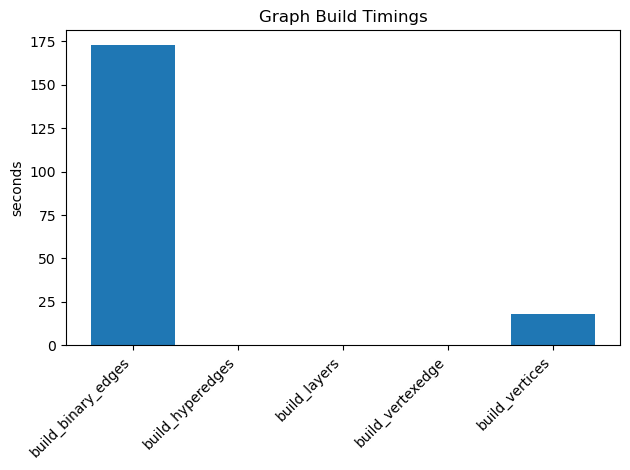

In [48]:
# Timing summary
import pandas as pd

timings = {
    "build_layers": build_layers_time,
    "build_vertices": build_vertices_time,
    "build_binary_edges": build_binary_time,
    "build_hyperedges": build_hyper_time,
    "build_vertexedge": build_vertexedge_time,
}

df = pd.DataFrame(sorted(timings.items(), key=lambda x: x[0]), columns=["stage","seconds"])

print("Build timings (seconds)", df)

# Simple chart
import matplotlib.pyplot as plt
plt.figure()
plt.bar(df["stage"], df["seconds"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("seconds")
plt.title("Graph Build Timings")
plt.tight_layout()
plt.show()
